In [402]:
import pandas as pd
import pickle 
import re
import numpy as np
from collections import defaultdict
import missingno as msno
import seaborn as sns

pd.set_option('display.max_rows', None)  # Без ограничений по строкам
pd.set_option('display.max_columns', None)  # Без ограничений по столбцам
pd.set_option('display.width', None)  # Автоматическая ширина вывода
pd.set_option('display.max_colwidth', None)

In [403]:
with open('PSB/data/target_train.csv', 'rb') as handle:
    df_train = pd.read_csv(handle)

with open('PSB/data/target_test.csv', 'rb') as handle:
    df_test = pd.read_csv(handle)

with open('PSB/data/df_merged_pre_final.csv', 'rb') as handle:
    full_data = pd.read_csv(handle)



In [404]:
financial_features = [col for col in full_data.columns if re.match(r"20\d{2}_\d+_\d+(\.\d+)?", col)]
features_by_code = defaultdict(list)
for col in financial_features:
    parts = col.split("_")
    if len(parts) >= 2:
        code = parts[1]
        features_by_code[code].append(col)

for code, cols in features_by_code.items():
    cols_sorted = sorted(cols)
    full_data[f"{code}_mean"] = full_data[cols_sorted].mean(axis=1)
    full_data[f"{code}_std"] = full_data[cols_sorted].std(axis=1)
    # full_data[f"{code}_trend"] = full_data[cols_sorted].apply(lambda row: np.polyfit(range(len(row)), row, 1)[0], axis=1)
    full_data[f"{code}_growth"] = full_data[cols_sorted[-1]] / (full_data[cols_sorted[0]] + 1e-6) * 100

print(features_by_code.keys())

dict_keys(['1300', '1600', '1700', '2110', '2400'])


<Axes: >

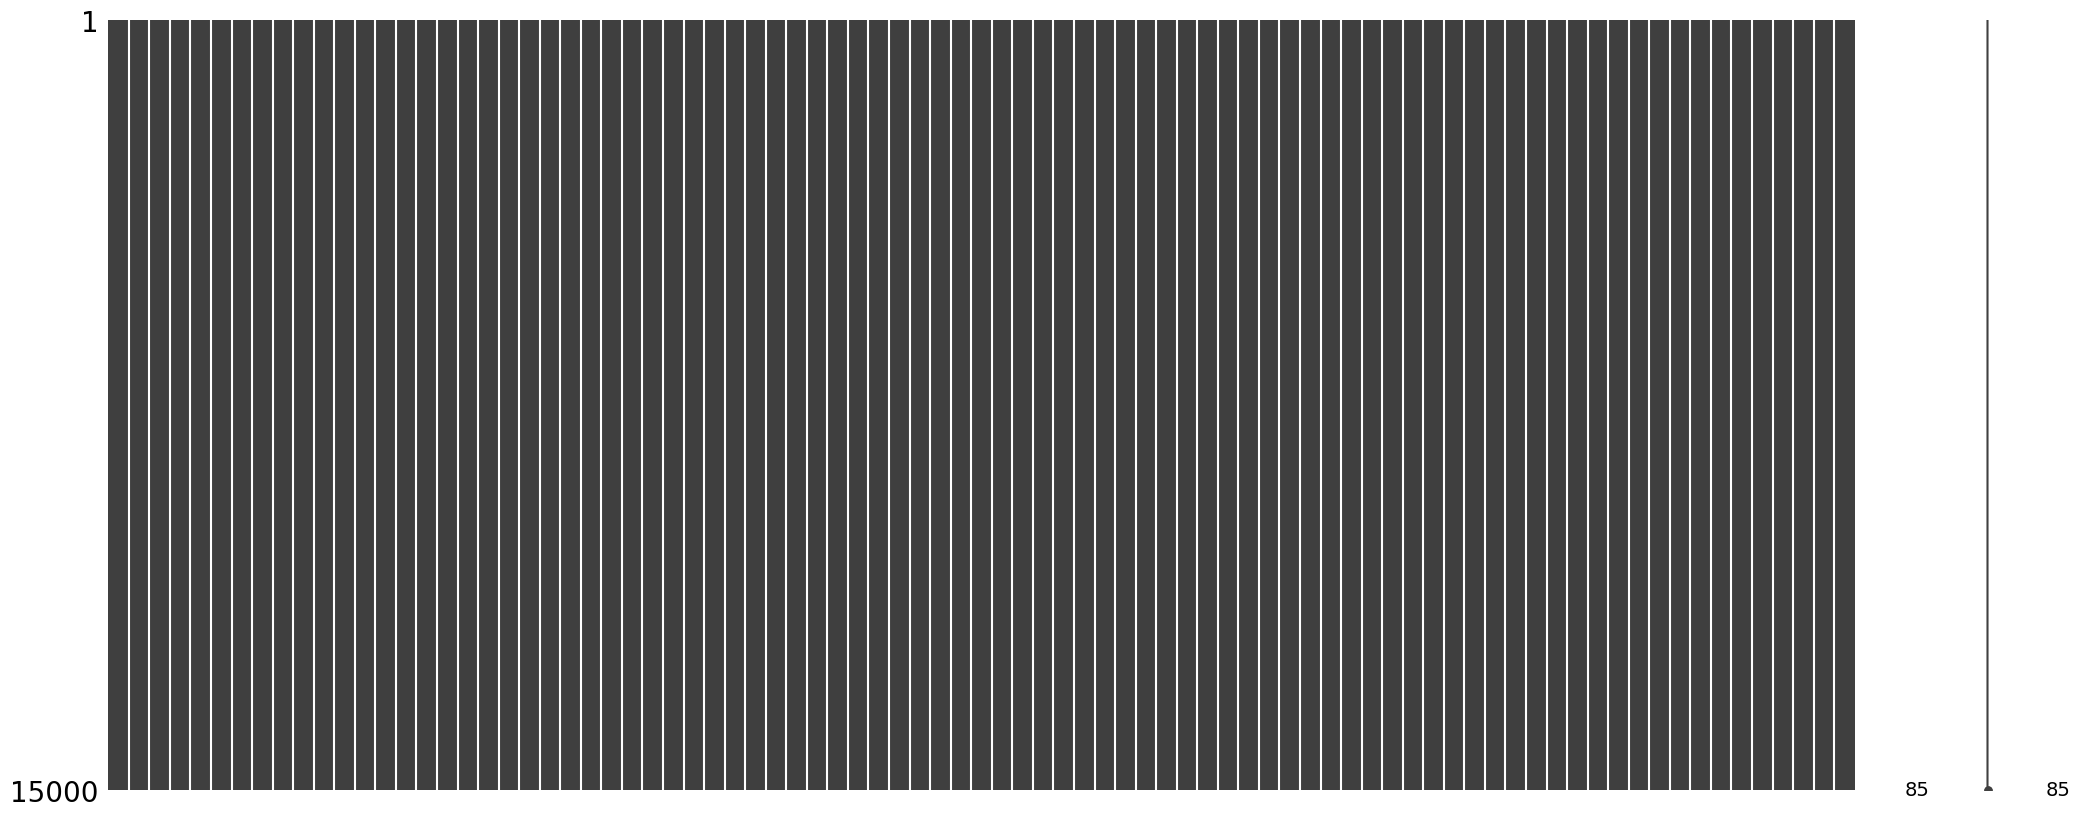

In [405]:
# Ликвидность и платежеспособность
if '1300' in features_by_code and '1500' in features_by_code:
    # Коэффициент текущей ликвидности
    full_data['current_ratio'] = full_data['1300_mean'] / (full_data['1500_mean'] + 1e-6)

    # Коэффициент быстрой ликвидности (если есть 1200 - оборотные активы)
    if '1200' in features_by_code:
        full_data['quick_ratio'] = (full_data['1200_mean']) / (full_data['1500_mean'] + 1e-6)

# Финансовая устойчивость
if '1600' in features_by_code:
    if '1300' in features_by_code:
        # Коэффициент автономии
        full_data['equity_ratio'] = full_data['1300_mean'] / (full_data['1600_mean'] + 1e-6)
    
    if '1400' in features_by_code and '1500' in features_by_code:
        # Коэффициент финансового рычага (левериджа)
        full_data['debt_ratio'] = (full_data['1400_mean'] + full_data['1500_mean']) / (full_data['1600_mean'] + 1e-6)

# Рентабельность
if '2400' in features_by_code:
    if '1600' in features_by_code:
        # Рентабельность активов (ROA)
        full_data['roa'] = full_data['2400_mean'] / (full_data['1600_mean'] + 1e-6)
    
    if '1300' in features_by_code:
        # Рентабельность собственного капитала (ROE)
        full_data['roe'] = full_data['2400_mean'] / (full_data['1300_mean'] + 1e-6)
    
    if '2110' in features_by_code:  # Если есть выручка
        # Рентабельность продаж (ROS)
        full_data['ros'] = full_data['2400_mean'] / (full_data['2110_mean'] + 1e-6)

# Оборачиваемость (если есть соответствующие данные)
if '2110' in features_by_code and '1600' in features_by_code:
    # Оборачиваемость активов
    full_data['asset_turnover'] = full_data['2110_mean'] / (full_data['1600_mean'] + 1e-6)

full_data = full_data.dropna(axis=1)
msno.matrix(full_data)

In [406]:
# Усиленные признаки динамики
# for code in features_by_code.keys():
#     if f'{code}_trend' in full_data.columns:
#         # Относительный тренд (нормализованный по среднему значению)
#         full_data[f'{code}_rel_trend'] = full_data[f'{code}_trend'] / (abs(full_data[f'{code}_mean']) + 1e-6)
        
#         # Вычисление коэффициента вариации
#         full_data[f'{code}_cv'] = full_data[f'{code}_std'] / (abs(full_data[f'{code}_mean']) + 1e-6)
        
#         # Признак устойчивого роста/падения
#         cols_sorted = sorted(features_by_code[code])
#         if len(cols_sorted) >= 2:  # Минимум 4 периода для анализа тренда
#             # Создаем признак стабильности тренда (1 - стабильный рост, -1 - стабильное падение, 0 - нестабильный)
#             full_data[f'{code}_trend_stability'] = full_data[cols_sorted].apply(
#                 lambda row: 1 if all(row[i] <= row[i+1] for i in range(len(row)-1)) else 
#                           (-1 if all(row[i] >= row[i+1] for i in range(len(row)-1)) else 0), 
#                 axis=1
#             )

print(features_by_code.keys())

dict_keys(['1300', '1600', '1700', '2110', '2400'])


In [407]:
# Модель Альтмана (Z-score) для прогнозирования банкротства
# Z-score = 1.2*T1 + 1.4*T2 + 3.3*T3 + 0.6*T4 + 1.0*T5
if all(code in features_by_code for code in ['1200', '1300', '1500', '2400', '2110']):
    # T1 = Оборотный капитал / Активы
    full_data['altman_t1'] = (full_data['1200_mean'] - full_data.get('1500_mean', 0)) / (full_data['1600_mean'] + 1e-6)
    print(full_data['altman_t1'])

    # T2 = Нераспределенная прибыль / Активы
    if '2400' in features_by_code:
        full_data['altman_t2'] = full_data['2400_mean'] / (full_data['1600_mean'] + 1e-6)
        print(full_data['altman_t2'])
    
    # T3 = EBIT / Активы
    if '2300' in features_by_code:  # Прибыль до налогообложения
        full_data['altman_t3'] = full_data['2300_mean'] / (full_data['1600_mean'] + 1e-6)
        print(full_data['altman_t3'])
        
    # T4 = Рыночная стоимость акций / Обязательства
    # (используем собственный капитал как приближение)
    if '1400' in features_by_code and '1500' in features_by_code:
        full_data['altman_t4'] = full_data['1300_mean'] / (full_data['1400_mean'] + full_data['1500_mean'] + 1e-6)
        print(full_data['altman_t4'])
    # T5 = Выручка / Активы
    full_data['altman_t5'] = full_data['2110_mean'] / (full_data['1600_mean'] + 1e-6)
    # print(full_data['altman_t5'])

    # Итоговый Z-score
    full_data['z_score'] = (
        1.2 * full_data.get('altman_t1', 0) + 
        1.4 * full_data.get('altman_t2', 0) + 
        3.3 * full_data.get('altman_t3', 0) + 
        0.6 * full_data.get('altman_t4', 0) + 
        1.0 * full_data.get('altman_t5', 0)
    )
full_data.head()

,Unnamed: 0.1,inn,data_ОКВЭД_Код,data_Налоги_СумУпл,data_Налоги_СумНедоим,data_УстКап_Сумма,data_Санкции,data_НелегалФин,Возраст_компании,Недостоверный_адрес,Особый_налоговый_режим,Массовый_учредитель,Есть_банкротство,Недобросовестный_поставщик,Среднесписочная_численность,Количество_дел,Общая_сумма,Среднее_по_делу,Максимальная_сумма,Последнее_дело_дата,Первое_дело_дата,Количество_дел_в_производстве,Всего_дел_в_системе,Длительность_судебной_истории,status_Действующая организация,status_Деятельность прекращена,status_Процесс банкротства,status_Процесс исключения,status_Процесс реорганизации,status_Стадия ликвидации,Категория_МСП_МАЛОЕ ПРЕДПРИЯТИЕ,Категория_МСП_МИКРОПРЕДПРИЯТИЕ,Категория_МСП_Неизвестно,Категория_МСП_СРЕДНЕЕ ПРЕДПРИЯТИЕ,Unnamed: 0,2022_1300_0,2022_1300_1,2022_1600_0,2022_1600_1,2022_1700_0,2022_1700_1,2022_2110_0,2022_2110_1,2022_2400_0,2022_2400_1,2023_1300_0,2023_1300_1,2023_1600_0,2023_1600_1,2023_1700_0,2023_1700_1,2023_2110_0,2023_2110_1,2023_2400_0,2023_2400_1,2024_1300_0,2024_1300_1,2024_1600_0,2024_1600_1,2024_1700_0,2024_1700_1,2024_2110_0,2024_2110_1,2024_2400_0,2024_2400_1,1300_mean,1300_std,1300_growth,1600_mean,1600_std,1600_growth,1700_mean,1700_std,1700_growth,2110_mean,2110_std,2110_growth,2400_mean,2400_std,2400_growth,equity_ratio,roa,roe,ros,asset_turnover
0,0,1001001390,2,2.478546e+08,2.072310e+07,15583520.0,0,0,30,0,0,0,0,0,163,589.0,7.658237e+08,1.300210e+06,9.239343e+07,2025.0,2011.0,0.0,589.0,14.0,1,0,0,0,0,0,0,0,1,0,3,265575000.0,250476000.0,868710000.0,491121000.0,868710000.0,491121000.0,1.771477e+09,2.060444e+09,1441000.0,60531000.0,223839000.0,265575000.0,568964000.0,868710000.0,568964000.0,868710000.0,1.979607e+09,1.771477e+09,-100498000.0,1441000.0,236864000.0,223839000.0,724687000.0,568964000.0,724687000.0,568964000.0,2.225792e+09,1.979607e+09,900000.0,-100498000.0,2.443613e+08,1.916231e+07,84.284665,6.818593e+08,1.634212e+08,65.495275,6.818593e+08,1.634212e+08,65.495275,1.964734e+09,1.746142e+08,111.748953,-2.278050e+07,6.442818e+07,-6974.184594,0.358375,-0.033409,-0.093225,-0.011595,2.881436
1,1,1001004095,20,1.695939e+07,0.000000e+00,32400.0,0,0,32,0,0,0,0,0,37,34.0,3.694155e+07,1.086516e+06,1.803287e+07,2024.0,2014.0,0.0,34.0,10.0,1,0,0,0,0,0,1,0,0,0,4,171441000.0,156979000.0,189731000.0,181744000.0,189731000.0,181744000.0,1.706430e+08,2.822530e+08,21910000.0,106543000.0,171235000.0,171441000.0,193352000.0,189731000.0,193352000.0,189731000.0,1.758600e+08,1.706430e+08,7243000.0,21910000.0,169797000.0,171235000.0,192447000.0,193352000.0,192447000.0,193352000.0,2.023990e+08,1.758600e+08,2183000.0,7243000.0,1.686880e+08,5.769974e+06,99.879842,1.900595e+08,4.398741e+06,101.908491,1.900595e+08,4.398741e+06,101.908491,1.962763e+08,4.376588e+07,103.057260,2.783867e+07,3.942397e+07,33.057964,0.887554,0.146473,0.165031,0.141834,1.032710
2,2,1001028755,46,4.668453e+06,0.000000e+00,10000.0,0,0,13,0,0,1,0,0,39,25.0,2.799794e+07,1.119918e+06,5.647302e+06,2023.0,2015.0,0.0,25.0,8.0,1,0,0,0,0,0,1,0,0,0,1,73295000.0,73460000.0,456052000.0,383302000.0,456052000.0,383302000.0,8.261840e+08,7.778040e+08,-161000.0,9035000.0,69080000.0,73299000.0,499412000.0,456056000.0,499412000.0,456056000.0,8.394260e+08,8.261840e+08,-4219000.0,-161000.0,69173000.0,69080000.0,532301000.0,499412000.0,532301000.0,499412000.0,9.074280e+08,8.394260e+08,93000.0,-4219000.0,7.123117e+07,2.323537e+06,94.249267,4.710892e+08,5.198068e+07,109.507688,4.710892e+08,5.198068e+07,109.507688,8.360753e+08,4.172501e+07,101.602791,6.133333e+04,4.842914e+06,2620.496894,0.151205,0.000130,0.000861,0.000073,1.774771
3,3,1001095007,46,5.535989e+06,0.000000e+00,210000.0,0,0,25,0,0,0,0,0,3,4.0,4.064346e+06,1.016087e+06,3.815452e+06,2023.0,2013.0,0.0,4.0,10.0,1,0,0,0,0,0,1,0,0,0,2,18625000.0,18239000.0,38058000.0,26388000.0,38058000.0,26388000.0,9.993000e+07,1.335050e+08,3376000.0,534000.0,17473000.0,18429000.0,24702000.0,37884000.0,24702000.0,37884000.0,7.620400e+07,9.993000e+07,308000.0,3181000.0,16949000.0,17473000.0,21702000.0,24748000.0,21

In [408]:
# ?Взаимодействия между ключевыми финансовыми показателями
# if '2400' in features_by_code and '1600' in features_by_code:
#     # Произведение рентабельности и волатильности (нестабильная прибыль - фактор риска)
#     # full_data['profit_volatility_risk'] = (full_data['2400_mean'] / (full_data['1600_mean'] + 1e-6)) * full_data['2400_cv']
    
#     # Взаимодействие между ростом выручки и трендом прибыли
#     if '2110' in features_by_code:
#         full_data['growth_profit_interaction'] = full_data['2110_growth'] * full_data['2400_trend']

# Темпы изменения ключевых показателей и их отношения
for code1, code2 in [('2400', '2110'), ('1300', '1500'), ('2200', '2110')]:
    if code1 in features_by_code and code2 in features_by_code:
        try:# Относительная динамика (например, динамика прибыли относительно динамики выручки)
           full_data[f'{code1}_{code2}_rel_trend'] = full_data[f'{code1}_trend'] / (abs(full_data[f'{code2}_trend']) + 1e-6)
        except Exception:
            pass

In [409]:
# Признаки на основе налоговых данных
if 'data_Налоги_СумУпл' in full_data.columns and 'data_Налоги_СумНедоим' in full_data.columns:
    # Доля недоимок в общей сумме налогов
    full_data['tax_arrears_ratio'] = full_data['data_Налоги_СумНедоим'] / (full_data['data_Налоги_СумУпл'] + full_data['data_Налоги_СумНедоим'] + 1e-6)
    
    # Налоговая нагрузка
    if '2110' in features_by_code:
        full_data['tax_burden'] = full_data['data_Налоги_СумУпл'] / (full_data['2110_mean'] + 1e-6)

# Комбинированные признаки риска
# if 'data_Санкции' in full_data.columns and 'data_НелегалФин' in full_data.columns:
#     # Общий индикатор риска
#     full_data['legal_risk_indicator'] = full_data['data_Санкции'] + 2 * full_data['data_НелегалФин']
    
#     # Взаимодействие юридических рисков с возрастом компании
#     if 'Возраст_компании' in full_data.columns:
#         full_data['age_adjusted_risk'] = full_data['legal_risk_indicator'] / (full_data['Возраст_компании'] + 1)

# full_data.info()

In [410]:
# Если есть информация о судебных делах
if all(col in full_data.columns for col in ['Количество_дел', 'Общая_сумма', 'Среднее_по_делу']):
    # Относительный размер судебных исков
    if '1600' in features_by_code:
        full_data['litigation_to_assets_ratio'] = full_data['Общая_сумма'] / (full_data['1600_mean'] + 1e-6)
    
    # Частота судебных дел относительно возраста компании
    if 'Возраст_компании' in full_data.columns:
        full_data['litigation_frequency'] = full_data['Количество_дел'] / (full_data['Возраст_компании'] + 1)
    
    # Тренд судебной активности
    if 'Последнее_дело_дата' in full_data.columns and 'Первое_дело_дата' in full_data.columns:
        date_diff = full_data['Последнее_дело_дата'] - full_data['Первое_дело_дата']
        full_data['litigation_intensity'] = full_data['Количество_дел'] / (date_diff + 1)

In [411]:
full_data = full_data.drop(columns='Unnamed: 0')
full_data.info()
df_train.info()

train_data = df_train.merge(full_data, left_on='inn', right_on='inn')
test_data = df_test.merge(full_data, left_on='inn', right_on='inn')

# Проблема с именованием
# train_data = train_data.merge(test_data, left_on='inn', right_on='inn')
# train_data.to_csv("PSB/data/train_data.csv")
# test_data.to_csv("PSB/data/test_data.csv")
train_data = train_data.dropna(axis=1)
test_data = test_data.dropna(axis=1)
# train_data["data_Санкции"] = round(train_data['data_Санкции'])
train_data = train_data.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
test_data = test_data.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
train_data.head()
# test_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 89 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0.1                       15000 non-null  int64  
 1   inn                                15000 non-null  int64  
 2   data_ОКВЭД_Код                     15000 non-null  int64  
 3   data_Налоги_СумУпл                 15000 non-null  float64
 4   data_Налоги_СумНедоим              15000 non-null  float64
 5   data_УстКап_Сумма                  15000 non-null  float64
 6   data_Санкции                       15000 non-null  int64  
 7   data_НелегалФин                    15000 non-null  int64  
 8   Возраст_компании                   15000 non-null  int64  
 9   Недостоверный_адрес                15000 non-null  int64  
 10  Особый_налоговый_режим             15000 non-null  int64  
 11  Массовый_учредитель                15000 non-null  int

,inn,target,data_ОКВЭД_Код,data_Налоги_СумУпл,data_Налоги_СумНедоим,data_УстКап_Сумма,data_Санкции,data_НелегалФин,Возраст_компании,Недостоверный_адрес,Особый_налоговый_режим,Массовый_учредитель,Есть_банкротство,Недобросовестный_поставщик,Среднесписочная_численность,Количество_дел,Общая_сумма,Среднее_по_делу,Максимальная_сумма,Последнее_дело_дата,Первое_дело_дата,Количество_дел_в_производстве,Всего_дел_в_системе,Длительность_судебной_истории,status_Действующая организация,status_Деятельность прекращена,status_Процесс банкротства,status_Процесс исключения,status_Процесс реорганизации,status_Стадия ликвидации,Категория_МСП_МАЛОЕ ПРЕДПРИЯТИЕ,Категория_МСП_МИКРОПРЕДПРИЯТИЕ,Категория_МСП_Неизвестно,Категория_МСП_СРЕДНЕЕ ПРЕДПРИЯТИЕ,2022_1300_0,2022_1300_1,2022_1600_0,2022_1600_1,2022_1700_0,2022_1700_1,2022_2110_0,2022_2110_1,2022_2400_0,2022_2400_1,2023_1300_0,2023_1300_1,2023_1600_0,2023_1600_1,2023_1700_0,2023_1700_1,2023_2110_0,2023_2110_1,2023_2400_0,2023_2400_1,2024_1300_0,2024_1300_1,2024_1600_0,2024_1600_1,2024_1700_0,2024_1700_1,2024_2110_0,2024_2110_1,2024_2400_0,2024_2400_1,1300_mean,1300_std,1300_growth,1600_mean,1600_std,1600_growth,1700_mean,1700_std,1700_growth,2110_mean,2110_std,2110_growth,2400_mean,2400_std,2400_growth,equity_ratio,roa,roe,ros,asset_turnover,tax_arrears_ratio,tax_burden,litigation_to_assets_ratio,litigation_frequency,litigation_intensity
0,5260112410,0,46,966978.89,0.00,10000.0,0,0,22,0,0,0,0,0,5,1.0,9.548635e+05,9.548635e+05,9.548635e+05,2023.0,2023.0,0.0,1.0,0.0,1,0,0,0,0,0,1,0,0,0,344000.0,166000.0,18324000.0,20854000.0,18324000.0,20854000.0,1.535030e+08,3.501560e+08,178000.0,661000.0,768000.0,344000.0,26068000.0,18324000.0,26068000.0,18324000.0,2.690360e+08,1.535030e+08,424000.0,178000.0,1094000.0,768000.0,28562000.0,26068000.0,28562000.0,26068000.0,2.323540e+08,2.690360e+08,326000.0,424000.0,5.806667e+05,3.514738e+05,223.255814,2.303333e+07,4.429214e+06,142.261515,2.303333e+07,4.429214e+06,142.261515,2.379313e+08,7.591676e+07,175.264327,3.651667e+05,1.822289e+05,238.202247,0.025210,0.015854,0.628875,0.001535,10.329870,0.000000,0.004064,0.041456,0.043478,1.000000
1,6311150391,0,47,5800685.53,0.00,10000.0,0,0,11,0,1,0,0,0,45,2.0,3.542988e+05,1.771494e+05,3.537988e+05,2021.0,2019.0,0.0,2.0,2.0,1,0,0,0,0,0,1,0,0,0,43137000.0,32900000.0,55945000.0,60697000.0,55945000.0,60697000.0,1.912390e+08,1.789670e+08,12290000.0,24987000.0,44211000.0,43137000.0,59836000.0,55945000.0,59836000.0,55945000.0,1.769380e+08,1.912390e+08,1904000.0,12290000.0,42708000.0,44211000.0,55528000.0,59836000.0,55528000.0,59836000.0,1.831750e+08,1.769380e+08,400000.0,1904000.0,4.171733e+07,4.363357e+06,102.489742,5.796450e+07,2.390183e+06,106.955045,5.796450e+07,2.390183e+06,106.955045,1.830827e+08,6.715842e+06,92.521923,8.962500e+06,9.506738e+06,15.492270,0.719705,0.154621,0.214839,0.048953,3.158531,0.000000,0.031683,0.006112,0.166667,0.666667
2,7810027596,0,46,29543894.35,0.00,10000000.0,0,0,19,0,0,0,0,0,171,212.0,1.970640e+08,9.295469e+05,1.222587e+08,2025.0,2007.0,0.0,212.0,18.0,1,0,0,0,0,0,0,0,1,0,33401000.0,28934000.0,811970000.0,924817000.0,811970000.0,924817000.0,1.690106e+09,1.459681e+09,4467000.0,4045000.0,38107000.0,33401000.0,868299000.0,811970000.0,868299000.0,811970000.0,1.901274e+09,1.690106e+09,4706000.0,4467000.0,43525000.0,38107000.0,969169000.0,868299000.0,969169000.0,868299000.0,2.200334e+09,1.901274e+09,5508000.0,4706000.0,3.591250e+07,5.077333e+06,114.089399,8.757540e+08,6.225993e+07,106.937325,8.757540e+08,6.225993e+07,106.937325,1.807129e+09,2.531583e+08,112.494364,4.649833e+06,4.848585e+05,105.350347,0.041008,0.005310,0.129477,0.002573,2.063512,0.000000,0.016349,0.225022,10.600000,11.157895
3,2465293875,1,47,1785567.35,41.26,100000.0,0,0,11,0,1,1,0,0,6,27.0,8.157456e+06,3.021280e+05,2.360018e+06,2024.0,2017.0,0.0,27.0,7.0,0,0,0,0,1,0,1,0,0,0,7000000.0,6133000.0,20220000.0,35138000.0,20220000.0,35138000.0,8.161600e+07,2.913680e+08,867000.0,2907000.0,7372000.0,7000000.0,19407000.0,20220000.0,19407000.0,20

In [412]:
# # Удаление отчетности по годам
# pattern_0 = r'^\d{4}_\d{4}_[01]$'
# cols_to_drop_0= [col for col in train_data.columns if re.fullmatch(pattern_0, col)]
# train_data = train_data.drop(columns=cols_to_drop_0)

# pattern_1 = r'^\d{4}_[A-Z]$'
# cols_to_drop_1= [col for col in train_data.columns if re.fullmatch(pattern_1, col)]
# train_data = train_data.drop(columns=cols_to_drop_1)

    # pattern = r'^\d+_.+$'
    # cols_to_drop = [col for col in train_data.columns if re.fullmatch(pattern, col)]
    # train_data = train_data.drop(columns=cols_to_drop)
    
okved_groups = {
    'A': (1, 3),
    'B': (5, 9),
    'C': (10, 33),
    'D': (35, 35),
    'E': (36, 39),
    'F': (41, 43),
    'G': (45, 47),
    'H': (49, 53),
    'I': (55, 56),
    'J': (58, 63)
}

for group, (min_code, max_code) in okved_groups.items():
    train_data[f"group_{group}"] = train_data["data_ОКВЭД_Код"].apply(
        lambda x: 1 if min_code <= x <= max_code else 0
    )


# train_data = train_data.drop(columns=["Особый_налоговый_режим", "Массовый_учредитель"], axis=1)
# train_data = train_data.drop(columns=["Особый_налоговый_режим", "data_ОКВЭД_Код", "altman_t1", "altman_t2", "altman_t3", "altman_t4", "altman_t5"], axis=1)
# train_data = train_data.drop(columns=["Особый_налоговый_режим", "data_ОКВЭД_Код"], axis=1)
# sns.heatmap(train_data.corr())
train_data = train_data.drop(columns="data_ОКВЭД_Код")
train_data.head()

,inn,target,data_Налоги_СумУпл,data_Налоги_СумНедоим,data_УстКап_Сумма,data_Санкции,data_НелегалФин,Возраст_компании,Недостоверный_адрес,Особый_налоговый_режим,Массовый_учредитель,Есть_банкротство,Недобросовестный_поставщик,Среднесписочная_численность,Количество_дел,Общая_сумма,Среднее_по_делу,Максимальная_сумма,Последнее_дело_дата,Первое_дело_дата,Количество_дел_в_производстве,Всего_дел_в_системе,Длительность_судебной_истории,status_Действующая организация,status_Деятельность прекращена,status_Процесс банкротства,status_Процесс исключения,status_Процесс реорганизации,status_Стадия ликвидации,Категория_МСП_МАЛОЕ ПРЕДПРИЯТИЕ,Категория_МСП_МИКРОПРЕДПРИЯТИЕ,Категория_МСП_Неизвестно,Категория_МСП_СРЕДНЕЕ ПРЕДПРИЯТИЕ,2022_1300_0,2022_1300_1,2022_1600_0,2022_1600_1,2022_1700_0,2022_1700_1,2022_2110_0,2022_2110_1,2022_2400_0,2022_2400_1,2023_1300_0,2023_1300_1,2023_1600_0,2023_1600_1,2023_1700_0,2023_1700_1,2023_2110_0,2023_2110_1,2023_2400_0,2023_2400_1,2024_1300_0,2024_1300_1,2024_1600_0,2024_1600_1,2024_1700_0,2024_1700_1,2024_2110_0,2024_2110_1,2024_2400_0,2024_2400_1,1300_mean,1300_std,1300_growth,1600_mean,1600_std,1600_growth,1700_mean,1700_std,1700_growth,2110_mean,2110_std,2110_growth,2400_mean,2400_std,2400_growth,equity_ratio,roa,roe,ros,asset_turnover,tax_arrears_ratio,tax_burden,litigation_to_assets_ratio,litigation_frequency,litigation_intensity,group_A,group_B,group_C,group_D,group_E,group_F,group_G,group_H,group_I,group_J
0,5260112410,0,966978.89,0.00,10000.0,0,0,22,0,0,0,0,0,5,1.0,9.548635e+05,9.548635e+05,9.548635e+05,2023.0,2023.0,0.0,1.0,0.0,1,0,0,0,0,0,1,0,0,0,344000.0,166000.0,18324000.0,20854000.0,18324000.0,20854000.0,1.535030e+08,3.501560e+08,178000.0,661000.0,768000.0,344000.0,26068000.0,18324000.0,26068000.0,18324000.0,2.690360e+08,1.535030e+08,424000.0,178000.0,1094000.0,768000.0,28562000.0,26068000.0,28562000.0,26068000.0,2.323540e+08,2.690360e+08,326000.0,424000.0,5.806667e+05,3.514738e+05,223.255814,2.303333e+07,4.429214e+06,142.261515,2.303333e+07,4.429214e+06,142.261515,2.379313e+08,7.591676e+07,175.264327,3.651667e+05,1.822289e+05,238.202247,0.025210,0.015854,0.628875,0.001535,10.329870,0.000000,0.004064,0.041456,0.043478,1.000000,0,0,0,0,0,0,1,0,0,0
1,6311150391,0,5800685.53,0.00,10000.0,0,0,11,0,1,0,0,0,45,2.0,3.542988e+05,1.771494e+05,3.537988e+05,2021.0,2019.0,0.0,2.0,2.0,1,0,0,0,0,0,1,0,0,0,43137000.0,32900000.0,55945000.0,60697000.0,55945000.0,60697000.0,1.912390e+08,1.789670e+08,12290000.0,24987000.0,44211000.0,43137000.0,59836000.0,55945000.0,59836000.0,55945000.0,1.769380e+08,1.912390e+08,1904000.0,12290000.0,42708000.0,44211000.0,55528000.0,59836000.0,55528000.0,59836000.0,1.831750e+08,1.769380e+08,400000.0,1904000.0,4.171733e+07,4.363357e+06,102.489742,5.796450e+07,2.390183e+06,106.955045,5.796450e+07,2.390183e+06,106.955045,1.830827e+08,6.715842e+06,92.521923,8.962500e+06,9.506738e+06,15.492270,0.719705,0.154621,0.214839,0.048953,3.158531,0.000000,0.031683,0.006112,0.166667,0.666667,0,0,0,0,0,0,1,0,0,0
2,7810027596,0,29543894.35,0.00,10000000.0,0,0,19,0,0,0,0,0,171,212.0,1.970640e+08,9.295469e+05,1.222587e+08,2025.0,2007.0,0.0,212.0,18.0,1,0,0,0,0,0,0,0,1,0,33401000.0,28934000.0,811970000.0,924817000.0,811970000.0,924817000.0,1.690106e+09,1.459681e+09,4467000.0,4045000.0,38107000.0,33401000.0,868299000.0,811970000.0,868299000.0,811970000.0,1.901274e+09,1.690106e+09,4706000.0,4467000.0,43525000.0,38107000.0,969169000.0,868299000.0,969169000.0,868299000.0,2.200334e+09,1.901274e+09,5508000.0,4706000.0,3.591250e+07,5.077333e+06,114.089399,8.757540e+08,6.225993e+07,106.937325,8.757540e+08,6.225993e+07,106.937325,1.807129e+09,2.531583e+08,112.494364,4.649833e+06,4.848585e+05,105.350347,0.041008,0.005310,0.129477,0.002573,2.063512,0.000000,0.016349,0.225022,10.600000,11.157895,0,0,0,0,0,0,1,0,0,0
3,2465293875,1,1785567.35,41.26,100000.0,0,0,11,0,1,1,0,0,6,27.0,8.157456e+06,3.021280e+05,2.360018e+06,2024.0,2017.0,0.0,27.0,7.0,0,0,0,0,1,0,1,0,0,0,7000000.0,6133000.0,20220000.0,35138000.0,20220000.

In [413]:
# 

<Axes: >

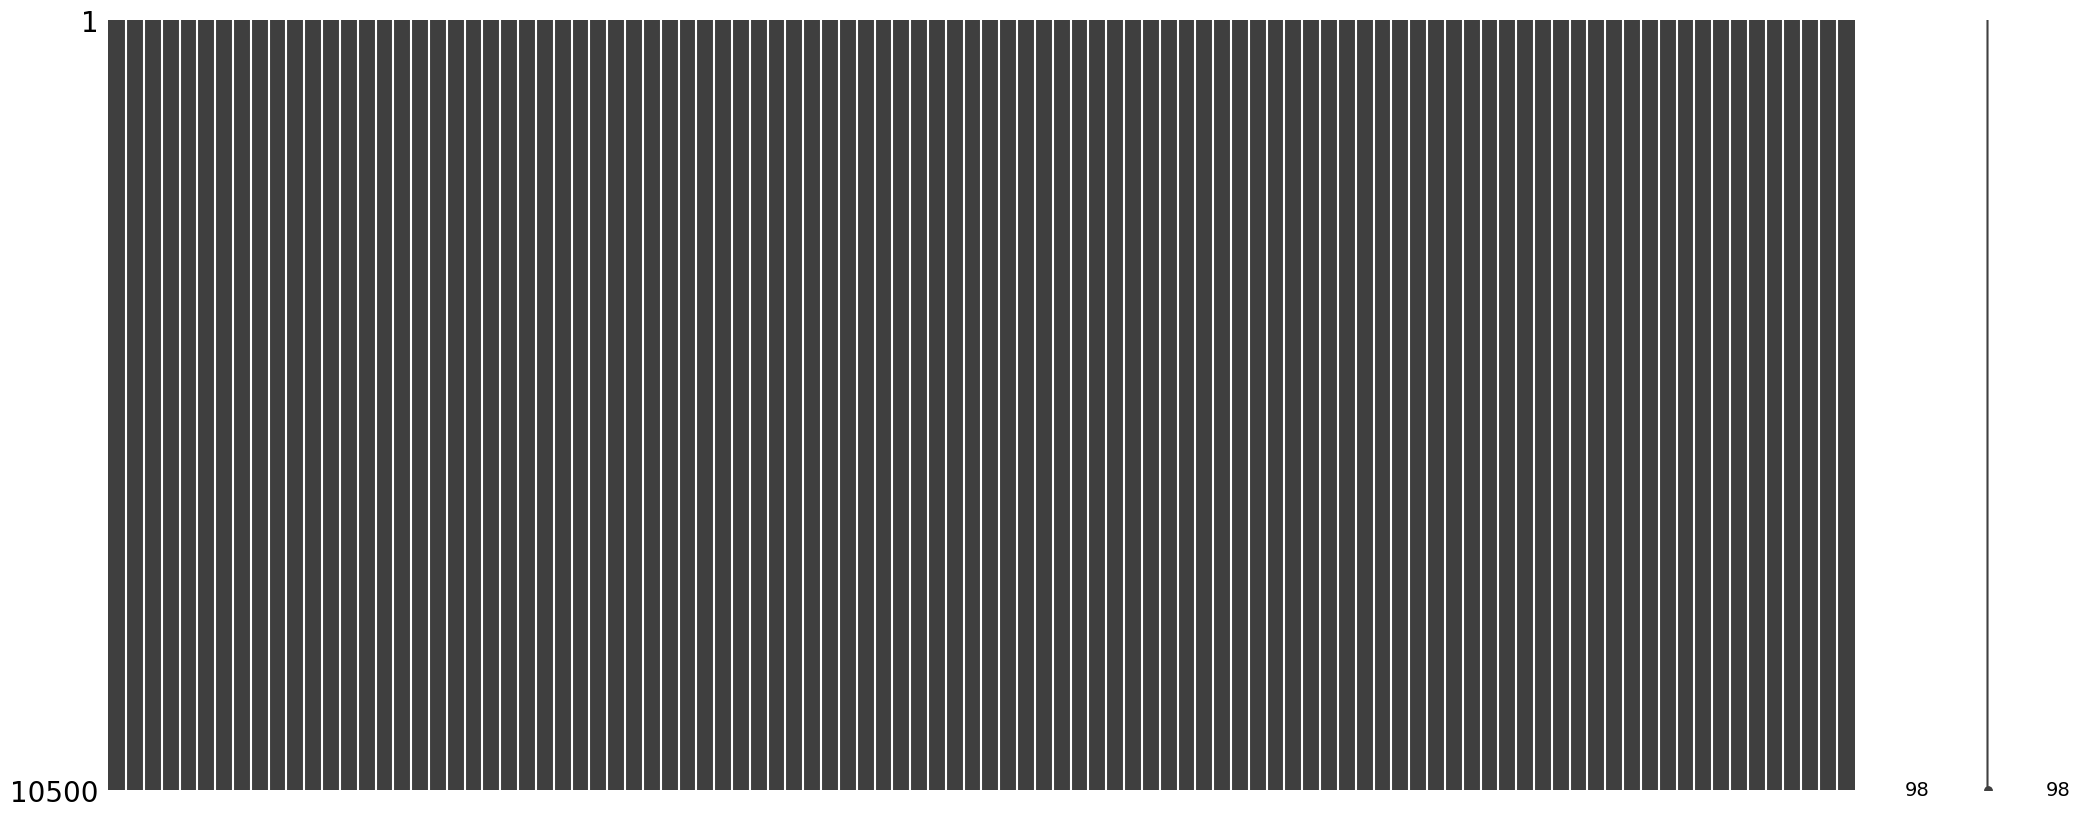

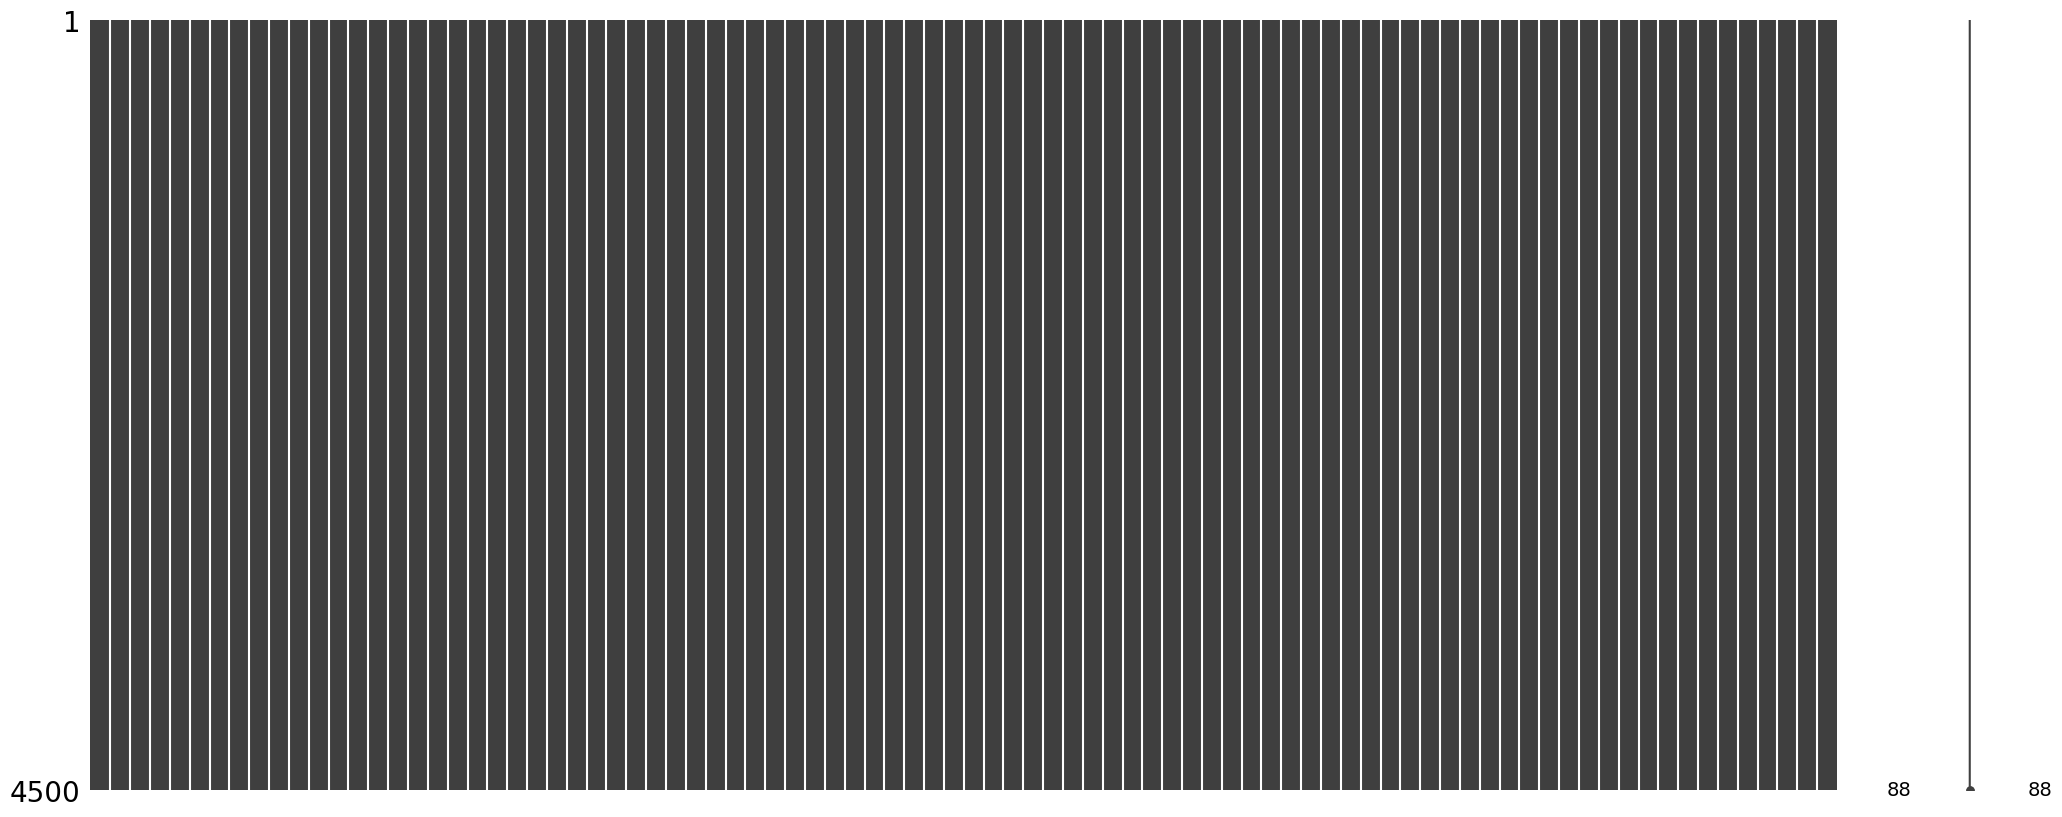

In [414]:

msno.matrix(train_data)
msno.matrix(test_data)


In [415]:
prewrite_train_data = train_data
prewrite_test_data = test_data

prewrite_train_data.to_csv("PSB/data/train_data.csv")
prewrite_train_data.to_csv("PSB/data/test_data.csv")

In [416]:
with open('PSB/data/train_df.pkl', 'wb') as handle:
    pickle.dump(train_data, handle)

with open('PSB/data/test_df.pkl', 'wb') as handle:
    pickle.dump(test_data, handle)